# Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras import backend as K

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)
/home/budmitr/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
train_biz_labels = pd.read_csv('data/train.csv')
train_photo_biz = pd.read_csv('data/train_photo_to_biz_ids.csv')

train_biz_labels.dropna(inplace=True)

# Some familiarity with the data

In [3]:
train_photo_biz.groupby('business_id').count().describe()

,photo_id
count,2000.000000
mean,117.421000
std,205.032768
min,2.000000
25%,34.000000
50%,61.000000
75%,117.000000
max,2974.000000


# Make a complete dataframe with separated labels for each photo

In [4]:
train = pd.merge(train_photo_biz, train_biz_labels, on='business_id')
categories = [
  'good_for_lunch', 
  'good_for_dinner', 
  'takes_reservations', 
  'outdoor_seating',
  'restaurant_is_expensive',
  'has_alcohol',
  'has_table_service',
  'ambience_is_classy',
  'good_for_kids'
]

train['file'] = 'data/train_photos/' + train['photo_id'].map(str) + '.jpg'
for i in range(len(categories)):
  train[categories[i]] = train['labels'].str.contains(str(i)).astype(int)
  
# And shuffle this (with fixed random seed for reproduceability)
# train = train.sample(frac=1, random_state=0)

In [15]:
train.tail()

,photo_id,business_id,labels,file,good_for_lunch,good_for_dinner,takes_reservations,outdoor_seating,restaurant_is_expensive,has_alcohol,has_table_service,ambience_is_classy,good_for_kids
234540,28845,2677,0 3 8,data/train_photos/28845.jpg,1,0,0,1,0,0,0,0,1
234541,152694,2677,0 3 8,data/train_photos/152694.jpg,1,0,0,1,0,0,0,0,1
234542,258784,2677,0 3 8,data/train_photos/258784.jpg,1,0,0,1,0,0,0,0,1
234543,237001,2677,0 3 8,data/train_photos/237001.jpg,1,0,0,1,0,0,0,0,1
234544,70063,2677,0 3 8,data/train_photos/70063.jpg,1,0,0,1,0,0,0,0,1


In [2]:
# VGG network pretraned (see https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

model.load_weights('models/vgg-16-pretrained/vgg16_weights.h5')

In [3]:
get_last_fc_vector = K.function([model.layers[0].input], [model.layers[-2].get_output(train=False)])

In [4]:
# https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 used BGR color model for this network
def rgb_to_brg(img):
  bgr = img.copy()
  bgr[:, :, 0] = img[:, :, 2]
  bgr[:, :, 2] = img[:, :, 0]
  return bgr

In [9]:
X = np.zeros((len(train), 4096), dtype=np.float32)
Y = np.array(train[categories]).astype(np.uint8)
ids = np.array(train[['photo_id', 'business_id']]).astype(np.uint32)

print X.shape, Y.shape, ids.shape

(234545, 4096) (234545, 9) (234545, 2)


In [10]:
idx = 0
for _, row in train.iterrows():
  print 'Train is completed, load it from data folder'
  break
  if idx < 139950: # used to continue interrupted process
    idx += 1
    continue
  
  # read and preprocess image
  im = misc.imresize(rgb_to_brg(misc.imread(row['file'])), (224, 224)).astype(np.float32)
  im[:,:,0] -= 103.939
  im[:,:,1] -= 116.779
  im[:,:,2] -= 123.68
  im = im.transpose((2,0,1))
  im = np.expand_dims(im, axis=0)
  
  X[idx] = np.array(get_last_fc_vector([im])).reshape(-1)
  
  # update iterators`
  idx += 1
  if idx % 100 == 0:
    print 'processed %d images' % idx

Train is completed, load it from data folder


# Preprocess test data

In [6]:
test_photo_biz = pd.read_csv('data/test_photo_to_biz.csv')
testphotoids = test_photo_biz['photo_id'].drop_duplicates()
testphotoids[:10]

0    317818
1     30679
2    455084
3    371381
4     86224
5     36076
6     46999
7     74896
8    169399
9    110581
Name: photo_id, dtype: int64

In [7]:
Xtest = np.zeros((len(testphotoids), 4096), dtype=np.float32)

In [12]:
idx = 0
for _, photo_id in testphotoids.iteritems():
  path = 'data/test_photos/' + str(photo_id) + '.jpg'

  # read and preprocess image
  im = misc.imresize(rgb_to_brg(misc.imread(path)), (224, 224)).astype(np.float32)
  im[:,:,0] -= 103.939
  im[:,:,1] -= 116.779
  im[:,:,2] -= 123.68
  im = im.transpose((2,0,1))
  im = np.expand_dims(im, axis=0)
  
  Xtest[idx] = np.array(get_last_fc_vector([im])).reshape(-1)
  
  # update iterators`
  idx += 1
  if idx % 100 == 0:
    print 'processed %d images' % idx

processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images
processed 1300 images
processed 1400 images
processed 1500 images
processed 1600 images
processed 1700 images
processed 1800 images
processed 1900 images
processed 2000 images
processed 2100 images
processed 2200 images
processed 2300 images
processed 2400 images
processed 2500 images
processed 2600 images
processed 2700 images
processed 2800 images
processed 2900 images
processed 3000 images
processed 3100 images
processed 3200 images
processed 3300 images
processed 3400 images
processed 3500 images
processed 3600 images
processed 3700 images
processed 3800 images
processed 3900 images
processed 4000 images
processed 4100 images
processed 4200 images
processed 4300 images
processed 4400 images
processed 4500 images
processed 4600 imag

In [13]:
np.save('data/Xtest.npy', Xtest)

# Display some photos

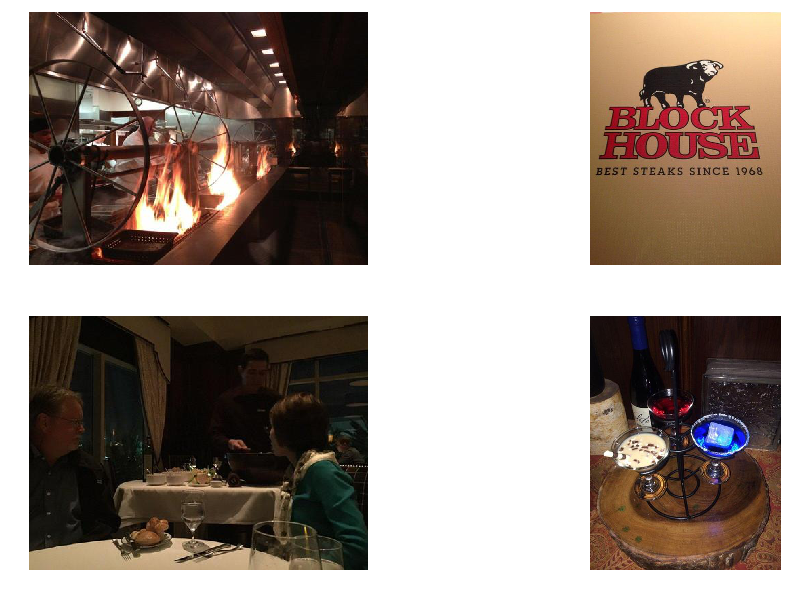

In [18]:
# https://www.kaggle.com/wendykan/yelp-restaurant-photo-classification/expensive-restaurants-look-like-this/notebook

x, n = 1, 2
for idx, row in train[train['restaurant_is_expensive'] == 1].sample(n ** 2).iterrows():
  plt.subplot(n, n, x)
  im = misc.imread(row['file'])
  plt.imshow(im)
  plt.axis('off')
  x += 1

# Is there some correlation between labels?

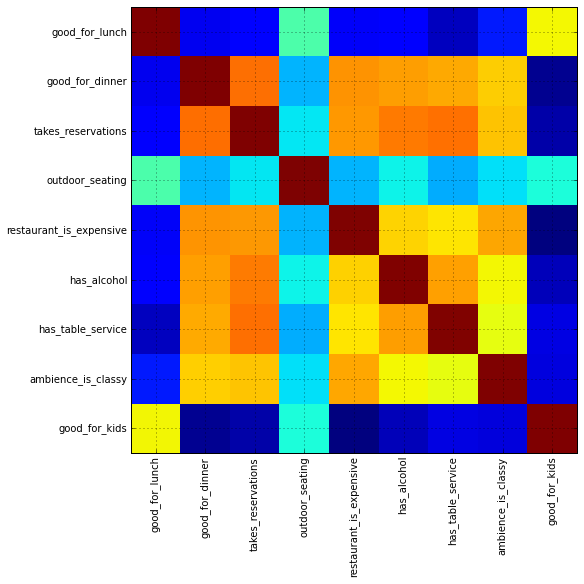

In [15]:
traincat = train[categories]
plt.imshow(traincat.corr(), interpolation='none')
plt.xticks(np.arange(len(categories)), categories, rotation='vertical')
plt.yticks(np.arange(len(categories)), categories)
plt.grid(True)